In [1]:
from Classicality_Algorithm import *

In [2]:
def quickrun_poly(theta, beta, r0=1, r1=1, r2=1, digits=14, fast_check_only=True, verbose=0):
    
    ##NB: angles_method only matters for method=inscribed, not for method=rejection.
    
    intro_t0 = time()
    
    A = Algorithm(EPS=np.float_power(10,-digits))

    
    #'polar' here means polar coordinates definied w.r.t the (y,x) frame, not (x,y).
    psi_polar = [r1, theta]
    phi_polar = [r2, -theta]
    psi_bar_polar = [r1, theta+np.pi]
    phi_bar_polar = [r2, -theta+np.pi]
    
    states_polar = [ psi_polar, phi_polar, psi_bar_polar, phi_bar_polar ]

    E_psi_polar = [r0, beta]
    E_phi_polar = [r0, beta+np.pi]
    
    effects_polar = states_polar + [ E_psi_polar, E_phi_polar ]
    
    
    #back to (x,y,z) cart coords.
    states_cart  = [ [r*np.cos(th), r*np.sin(th), 0] for r,th in states_polar]
    effects_cart = [ [r*np.cos(th), r*np.sin(th), 0] for r,th in effects_polar]
    
    
    A.Rhos     = [ A.bloch_vector_cart_coords_to_rho(x,y,z) for x,y,z in states_cart  ]
    A.Epsilons = [ A.bloch_vector_cart_coords_to_rho(x,y,z) for x,y,z in effects_cart ]
    
  
    algo_t0 = time()
    A.run_algorithm(verbose=verbose)
    
    
    try:
        the_2d_poly_s = convex_hull_of_2d_points( [[x,y] for x,y,z in states_cart] )
        the_2d_poly_e = convex_hull_of_2d_points( [[x,y] for x,y,z in effects_cart] )
    except:
        the_2d_poly_s = [[x,y] for x,y,z in states_cart]
        the_2d_poly_e = [[x,y] for x,y,z in effects_cart]
    
    
    return A, the_2d_poly_s, the_2d_poly_e

In [3]:
N_thetas = 45


thetas = np.linspace(0, np.pi/2, num=N_thetas, endpoint=True)
#make sure 'interesting' values of betas (it's classical when beta=theta or pi-theta):
betas = np.array(sorted(list(thetas) + list(np.pi - thetas)[:-1]))[:-1] #where we excluded the second pi/2, and the pi at the end.




t0 = time()

runs = []

for theta in tqdm(thetas):    
    for beta in betas:

        A, the_2d_poly_s, the_2d_poly_e = quickrun_poly(theta=theta, beta=beta, fast_check_only=False,verbose=0, digits=14)
        run = {'A':A}
        
        run['theta'] = theta
        run['beta'] = beta
        run['is_classical'] = A.is_classical
        run['distance_to_classicality'] = A.distance_to_classicality
        run['signed_distance_to_classicality'] = A.signed_distance_to_classicality
        
        run['is_classical_rounded'] = A.is_classical or (A.distance_to_classicality < A.EPS)
        
        run['2dpoly_s'] = the_2d_poly_s
        run['2dpoly_e'] = the_2d_poly_e
        
        runs.append( run )

    
print(humanize_duration(time()-t0))

100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


36.17s


In [4]:
import pickle
import os

# Store data if file doesn't exist

filepath = 'saved_calculations/distinguishability_runs/N_thetas_45__N_betas_90.pkl'

if not os.path.isfile(filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(runs, f)
else:
    print( f"Not saving { filepath.split('/')[-1] } because it already exists on disk. Choose a new name." )

    


Not saving N_thetas_45__N_betas_90.pkl because it already exists on disk. Choose a new name.


In [5]:
    
# Load data
with open('saved_calculations/distinguishability_runs/N_thetas_45__N_betas_90.pkl', 'rb') as f:
    runs = pickle.load(f)


In [6]:
thetas = np.array(sorted(list(set([run['theta'] for run in runs]))))
betas  = np.array(sorted(list(set([run['beta'] for run in runs]))))



runs_class = [run for run in runs if run['is_classical_rounded']]
runs_nonclass = [run for run in runs if not run['is_classical_rounded']]

In [7]:
def score(theta, beta, r0=1, r1=1, r2=1, alpha=0.5):
    return ( 1 + alpha*r0*r1*np.cos(theta-beta) - (1-alpha)*r0*r2*np.cos(theta+beta) )/2


def score_tilde(theta, beta, r0=1, r1=1, r2=1, alpha=0.5):
    
    score_one_guessing_choice      = score(theta, beta,       r0, r1, r2, alpha)
    score_opposite_guessing_choice = score(theta, beta+np.pi, r0, r1, r2, alpha)
    
    return max(score_one_guessing_choice, score_opposite_guessing_choice)

No handles with labels found to put in legend.


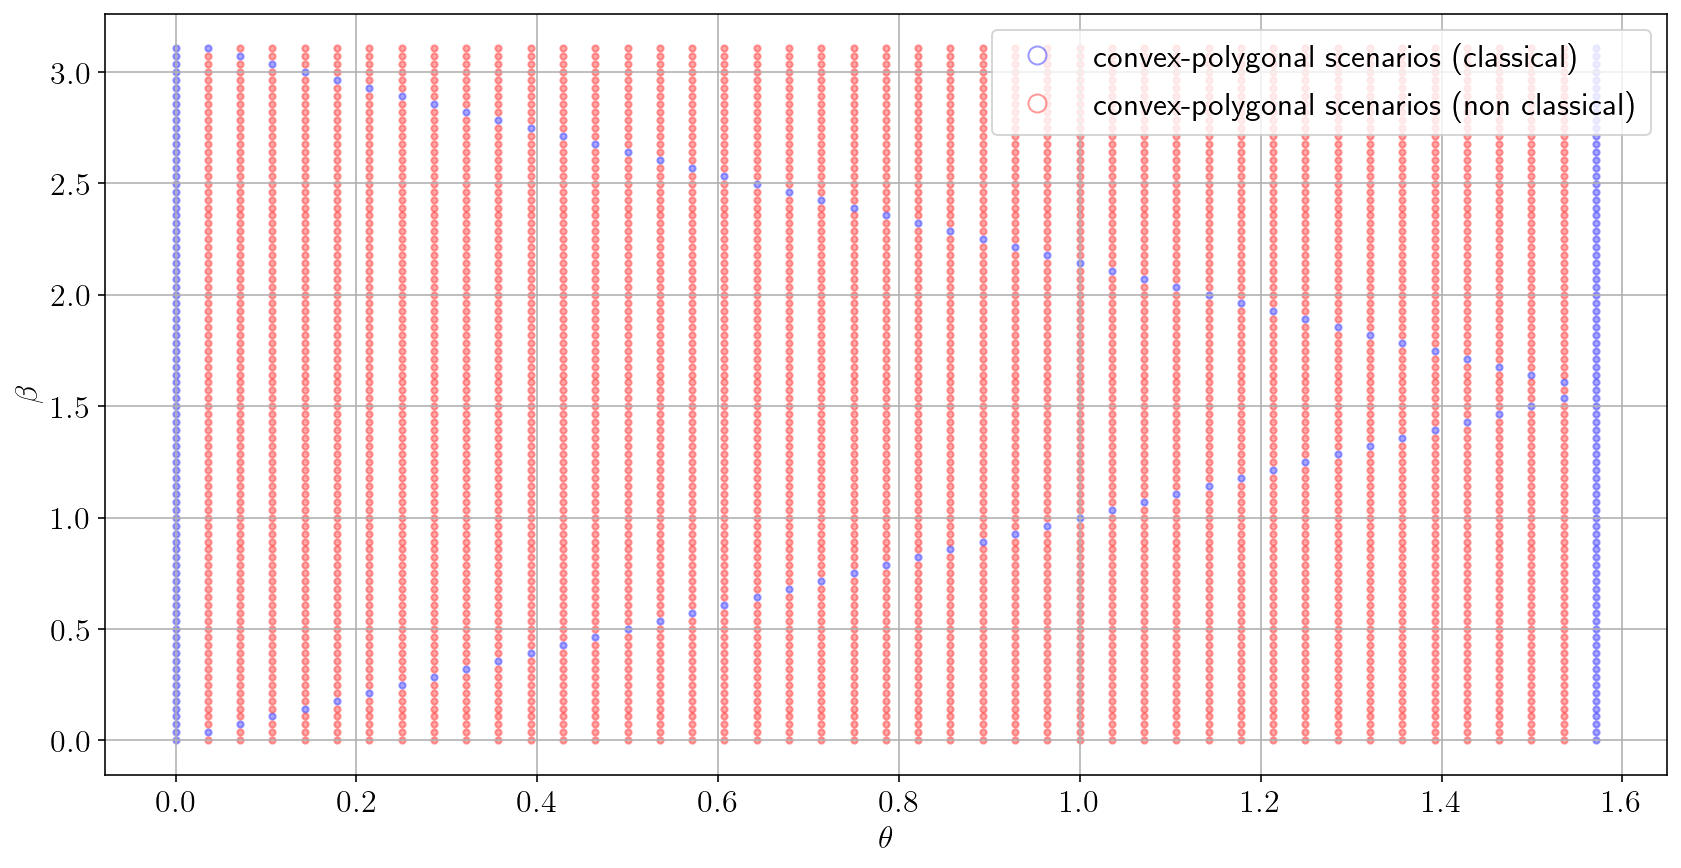

In [21]:
%config InlineBackend.figure_format = 'retina'


import matplotlib as mpl
import matplotlib.lines as mlines
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

mpl.rcParams.update({'font.size': 16})


classicality_colors = {True: 'blue', False: 'red'}
classicality_alphas = {True: 0.015, False: 0.6}
plt.figure(figsize=(14,7))


plt.scatter([run['theta'] for run in runs_class],
        [run['beta'] for run in runs_class],
        label=None,
        marker='o', s=10,
        edgecolors='blue', facecolors='blue',
        alpha=0.35)

plt.scatter([run['theta'] for run in runs_nonclass],
        [run['beta'] for run in runs_nonclass],
        label=None,
        marker='o', s=10,
        edgecolors='red', facecolors='red',
        alpha=0.35)





plt.grid()



plt.xlabel(r'$\theta$')

plt.ylabel(r'$\beta$')

plt.legend(prop={'size': 20})

handles, labels = plt.gca().get_legend_handles_labels()
classical_legend   = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='blue', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (classical)')
nonclassical_legend = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='red', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (non classical)')

handles = handles +[classical_legend, nonclassical_legend]

plt.legend(handles=handles)

plt.show()

No handles with labels found to put in legend.


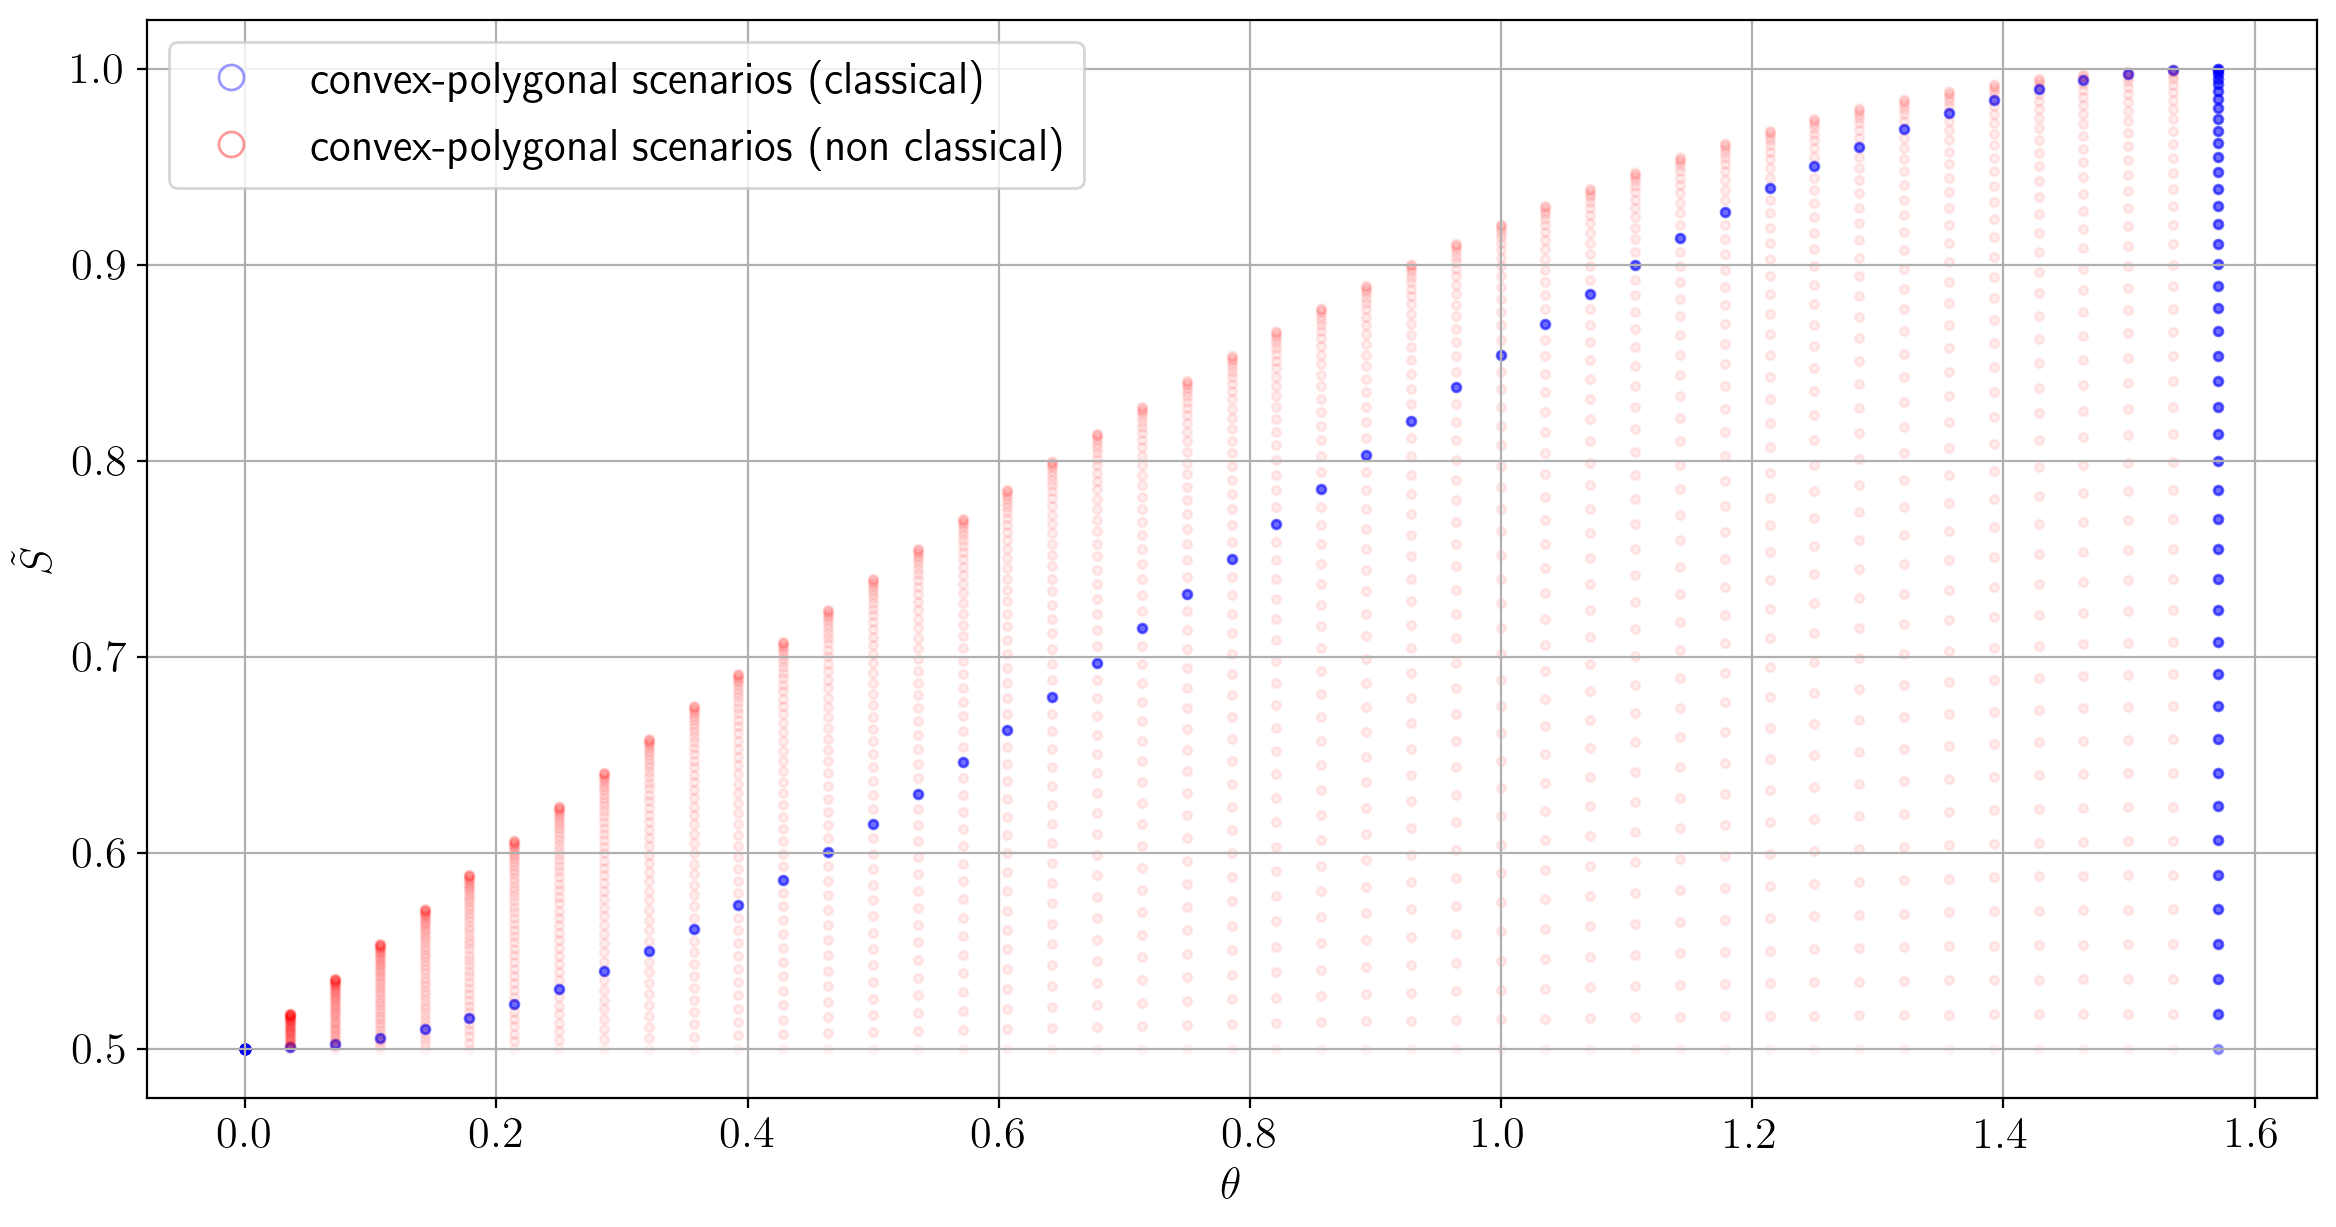

In [9]:
%config InlineBackend.figure_format = 'retina'


import matplotlib as mpl
import matplotlib.lines as mlines
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

mpl.rcParams.update({'font.size': 16})


classicality_colors = {True: 'blue', False: 'red'}
classicality_alphas = {True: 0.015, False: 0.6}
plt.figure(figsize=(14,7))


plt.scatter([run['theta'] for run in runs_class],
        [score_tilde(run['theta'],run['beta']) for run in runs_class],
        label=None,
        marker='o', s=10,
        edgecolors='blue', facecolors='blue',
        alpha=0.35)

plt.scatter([run['theta'] for run in runs_nonclass],
        [score_tilde(run['theta'],run['beta']) for run in runs_nonclass],
        label=None,
        marker='o', s=10,
        edgecolors='red', facecolors='red',
        alpha=0.035)




plt.grid()


plt.xlabel(r'$\theta$')

plt.ylabel(r'$\tilde{S}$')

plt.legend(prop={'size': 20})

handles, labels = plt.gca().get_legend_handles_labels()
classical_legend   = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='blue', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (classical)')
nonclassical_legend = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='red', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (non classical)')

handles = handles +[classical_legend, nonclassical_legend]

plt.legend(handles=handles)

plt.show()

No handles with labels found to put in legend.


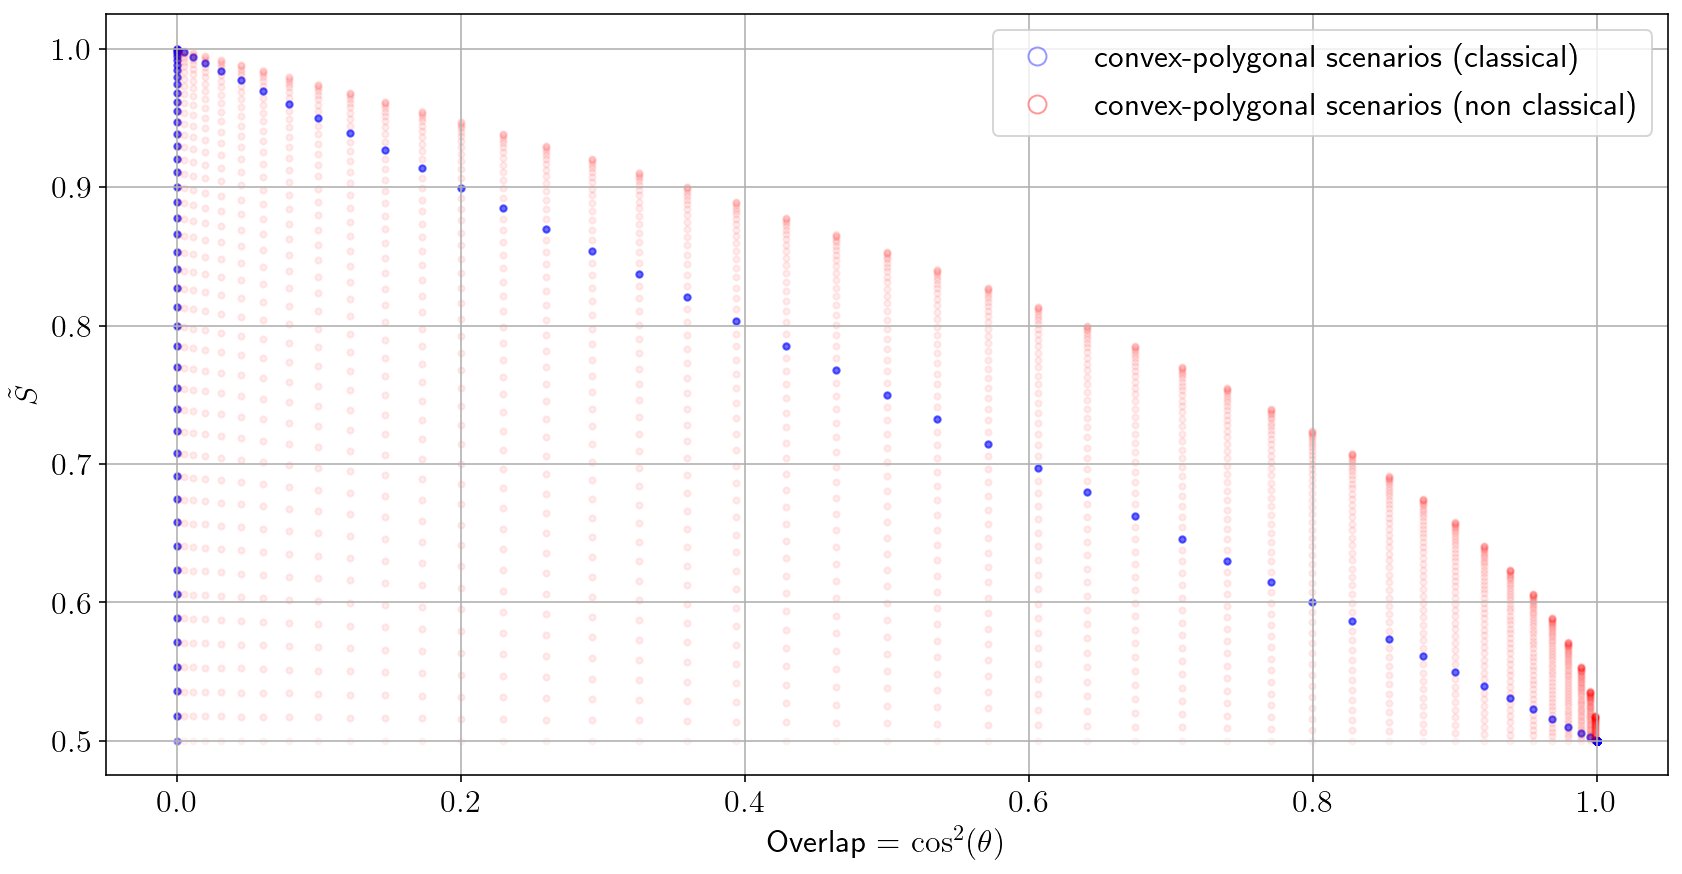

In [25]:
%config InlineBackend.figure_format = 'retina'


import matplotlib as mpl
import matplotlib.lines as mlines
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

mpl.rcParams.update({'font.size': 16})


classicality_colors = {True: 'blue', False: 'red'}
classicality_alphas = {True: 0.015, False: 0.6}
plt.figure(figsize=(14,7))


plt.scatter([np.cos(run['theta'])**2 for run in runs_class],
        [score_tilde(run['theta'],run['beta']) for run in runs_class],
        label=None,
        marker='o', s=10,
        edgecolors='blue', facecolors='blue',
        alpha=0.35)

plt.scatter([np.cos(run['theta'])**2 for run in runs_nonclass],
        [score_tilde(run['theta'],run['beta']) for run in runs_nonclass],
        label=None,
        marker='o', s=10,
        edgecolors='red', facecolors='red',
        alpha=0.035)



plt.grid()

plt.xlabel(r'Overlap = $\cos^2(\theta)$')

plt.ylabel(r'$\tilde{S}$')

plt.legend(prop={'size': 20})

handles, labels = plt.gca().get_legend_handles_labels()
classical_legend   = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='blue', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (classical)')
nonclassical_legend = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='red', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (non classical)')

handles = handles +[classical_legend, nonclassical_legend]

plt.legend(handles=handles)

plt.show()

No handles with labels found to put in legend.


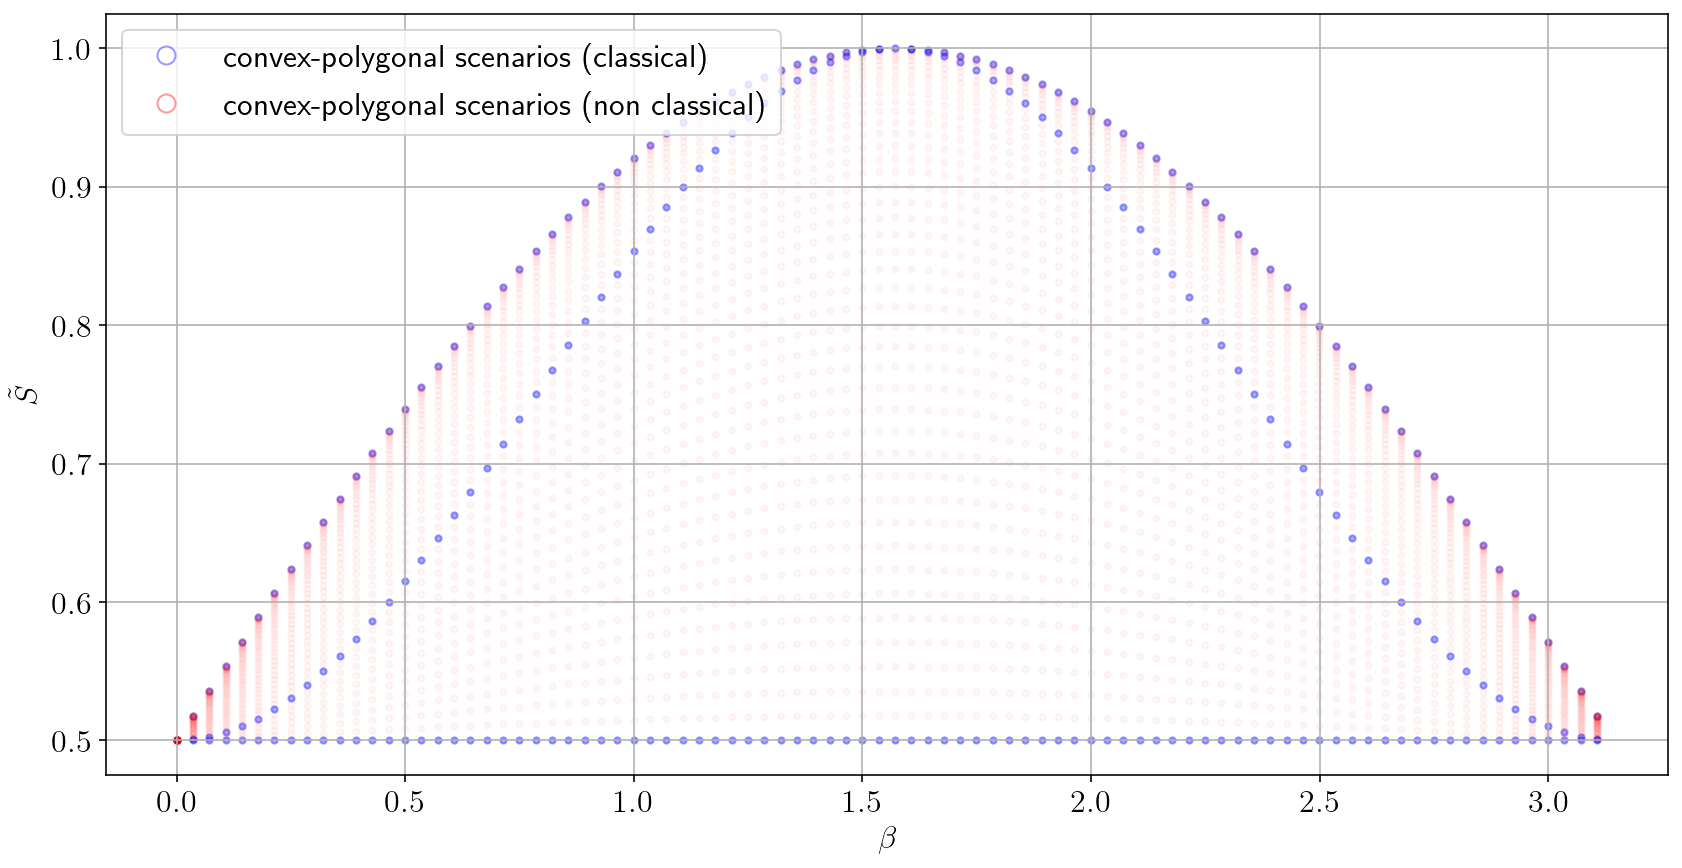

In [27]:
%config InlineBackend.figure_format = 'retina'


import matplotlib as mpl
import matplotlib.lines as mlines
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

mpl.rcParams.update({'font.size': 16})


classicality_colors = {True: 'blue', False: 'red'}
classicality_alphas = {True: 0.015, False: 0.6}
plt.figure(figsize=(14,7))


plt.scatter([run['beta'] for run in runs_class],
        [score_tilde(run['theta'],run['beta']) for run in runs_class],
        label=None,
        marker='o', s=10,
        edgecolors='blue', facecolors='blue',
        alpha=0.35)

plt.scatter([run['beta'] for run in runs_nonclass],
        [score_tilde(run['theta'],run['beta']) for run in runs_nonclass],
        label=None,
        marker='o', s=10,
        edgecolors='red', facecolors='red',
        alpha=0.035)


plt.grid()


plt.xlabel(r'$\beta$')

plt.ylabel(r'$\tilde{S}$')

plt.legend(prop={'size': 20})

handles, labels = plt.gca().get_legend_handles_labels()
classical_legend   = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='blue', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (classical)')
nonclassical_legend = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='red', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (non classical)')

handles = handles +[classical_legend, nonclassical_legend]

plt.legend(handles=handles)

plt.show()

No handles with labels found to put in legend.


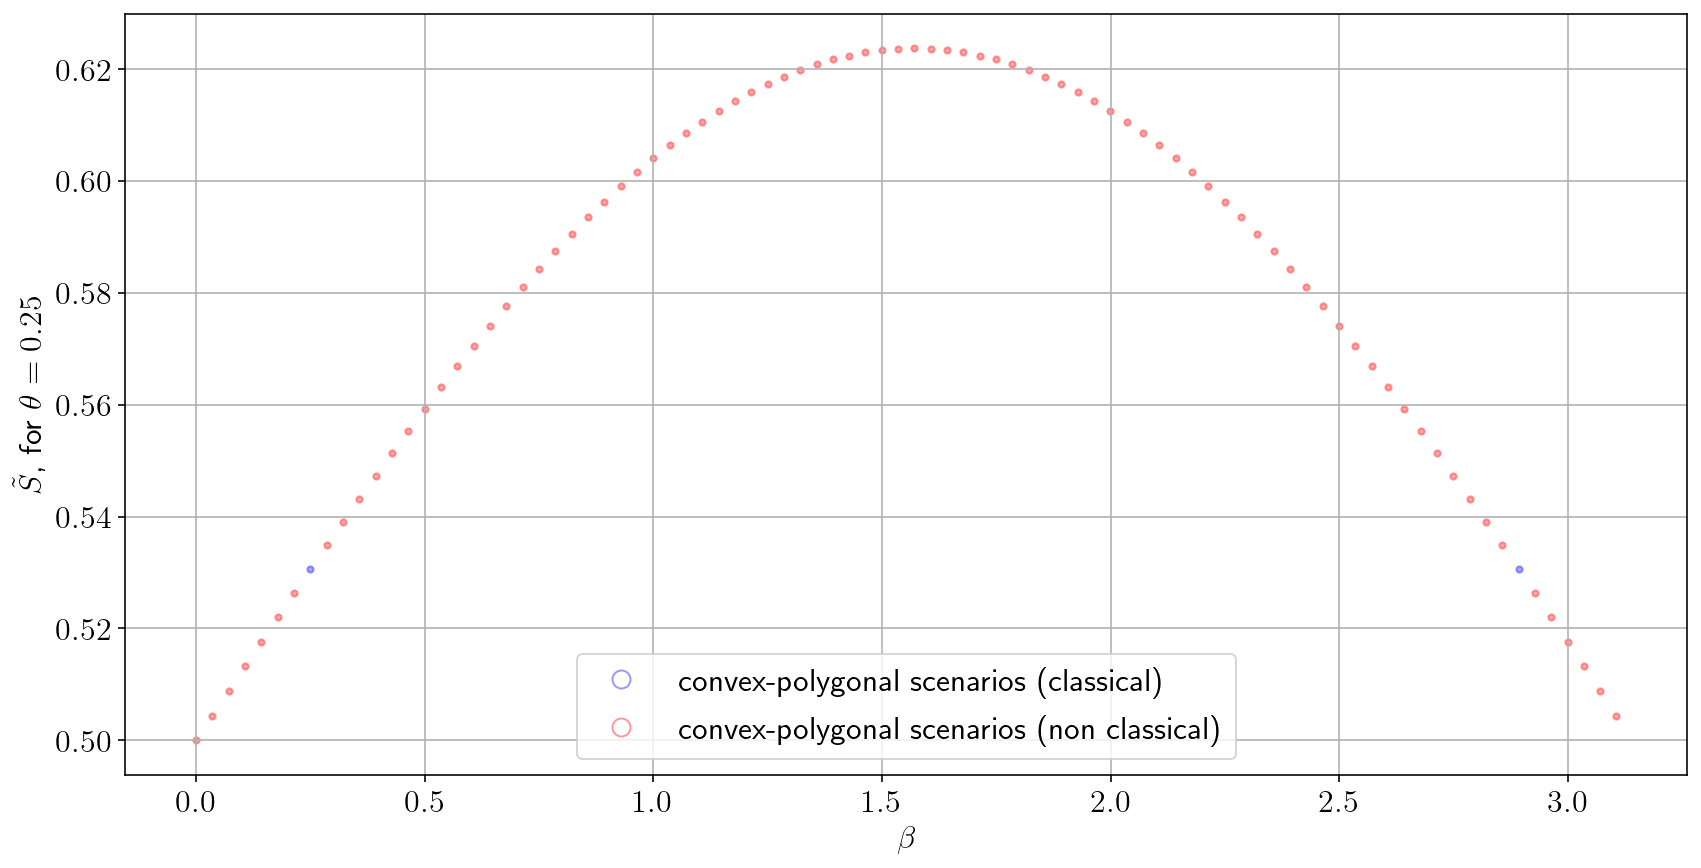

In [30]:
fixed_theta_i = 7

runs_class_fixed_theta    = [ run for run in runs_class    if run['theta']==thetas[fixed_theta_i] ]
runs_nonclass_fixed_theta = [ run for run in runs_nonclass if run['theta']==thetas[fixed_theta_i] ]


%config InlineBackend.figure_format = 'retina'


import matplotlib as mpl
import matplotlib.lines as mlines
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

mpl.rcParams.update({'font.size': 16})


classicality_colors = {True: 'blue', False: 'red'}
classicality_alphas = {True: 0.015, False: 0.6}
plt.figure(figsize=(14,7))


plt.scatter([run['beta'] for run in runs_class_fixed_theta],
        [ score_tilde(run['theta'],run['beta']) for run in runs_class_fixed_theta],
        label=None,
        marker='o', s=10,
        edgecolors='blue', facecolors='blue',
        alpha=0.35)

plt.scatter([run['beta'] for run in runs_nonclass_fixed_theta],
        [ score_tilde(run['theta'],run['beta']) for run in runs_nonclass_fixed_theta],
        label=None,
        marker='o', s=10,
        edgecolors='red', facecolors='red',
        alpha=0.35)



plt.grid()

plt.xlabel(r'$\beta$')

plt.ylabel(r'$\tilde{S}$, for $\theta='+str(np.round(thetas[fixed_theta_i],2))+r'$')

plt.legend(prop={'size': 20})

handles, labels = plt.gca().get_legend_handles_labels()
classical_legend   = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='blue', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (classical)')
nonclassical_legend = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='red', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (non classical)')

handles = handles +[classical_legend, nonclassical_legend]

plt.legend(handles=handles)


plt.show()

In [13]:
thetas

array([0.        , 0.03569992, 0.07139983, 0.10709975, 0.14279967,
       0.17849958, 0.2141995 , 0.24989942, 0.28559933, 0.32129925,
       0.35699917, 0.39269908, 0.428399  , 0.46409891, 0.49979883,
       0.53549875, 0.57119866, 0.60689858, 0.6425985 , 0.67829841,
       0.71399833, 0.74969825, 0.78539816, 0.82109808, 0.856798  ,
       0.89249791, 0.92819783, 0.96389775, 0.99959766, 1.03529758,
       1.0709975 , 1.10669741, 1.14239733, 1.17809725, 1.21379716,
       1.24949708, 1.28519699, 1.32089691, 1.35659683, 1.39229674,
       1.42799666, 1.46369658, 1.49939649, 1.53509641, 1.57079633])

No handles with labels found to put in legend.


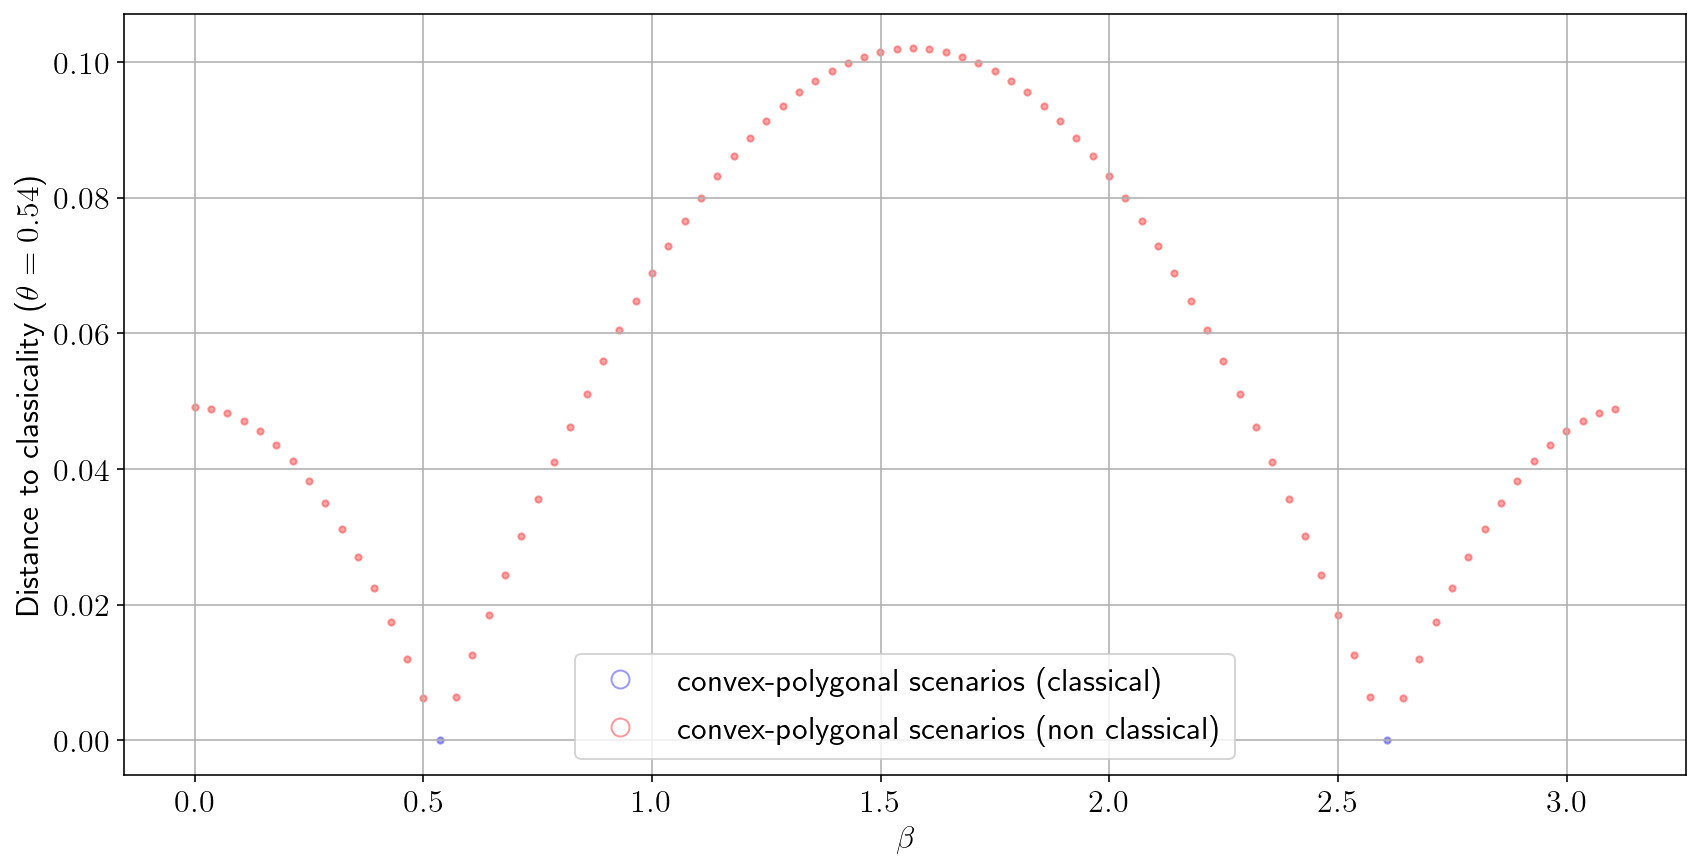

In [28]:
fixed_theta_i = 15

runs_class_fixed_theta    = [ run for run in runs_class    if run['theta']==thetas[fixed_theta_i] ]
runs_nonclass_fixed_theta = [ run for run in runs_nonclass if run['theta']==thetas[fixed_theta_i] ]

for run in runs_class_fixed_theta:
    run['A'].perform_second_step_cone_calculations()
for run in runs_nonclass_fixed_theta:
    run['A'].perform_second_step_cone_calculations()
       

%config InlineBackend.figure_format = 'retina'


import matplotlib as mpl
import matplotlib.lines as mlines
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

mpl.rcParams.update({'font.size': 16})


classicality_colors = {True: 'blue', False: 'red'}
classicality_alphas = {True: 0.015, False: 0.6}
plt.figure(figsize=(14,7))


plt.scatter([run['beta'] for run in runs_class_fixed_theta],
        [ run['A'].distance_to_classicality for run in runs_class_fixed_theta],
        label=None,
        marker='o', s=10,
        edgecolors='blue', facecolors='blue',
        alpha=0.35)

plt.scatter([run['beta'] for run in runs_nonclass_fixed_theta],
        [ run['A'].distance_to_classicality for run in runs_nonclass_fixed_theta],
        label=None,
        marker='o', s=10,
        edgecolors='red', facecolors='red',
        alpha=0.35)



plt.grid()

plt.xlabel(r'$\beta$')

plt.ylabel(r'Distance to classicality (' + r'$\theta='+str(np.round(thetas[fixed_theta_i],2))+r'$' + ')')

plt.legend(prop={'size': 20})

handles, labels = plt.gca().get_legend_handles_labels()
classical_legend   = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='blue', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (classical)')
nonclassical_legend = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='red', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (non classical)')

handles = handles +[classical_legend, nonclassical_legend]

plt.legend(handles=handles)

plt.show()

Conclusions:

The distinguishability game scenarios (at least, for $r_0=r_1=r_2=1$) are **always** nonclassical, except:
- in the cases where: $\beta=\theta$ or $\beta=\pi-\theta$ (i.e. special case where $\mathtt{s}=\mathtt{e}$, i.e. when the third effect dotted line on *Schmid_Spekkens_2018, Fig.1* coincides with one of the 2 other state dotted lines, i.e. we choose as the guessing measurement the orthogonal measurement of one of the two states  ).
- or, in the case where $\theta=0$ or $\theta=\pi/2$ (any $\beta$), i.e. the guessing game we're trying to play is impossible, or trivial, respectively.

--> Should do scans to check if, actually, for scenarios only with vertices on the unit circle:

- $\big(|\mathtt{s}|=4, |\mathtt{e}|=6 \big)$ is always NonClass ?

- $\big(|\mathtt{s}|=4, |\mathtt{e}|=4 \big)$ is always Class ?
- $\big(|\mathtt{s}|=2, |\mathtt{e}|=4 \big)$ is always Class ?
- $\big(|\mathtt{s}|=2, |\mathtt{e}|=2 \big)$ is always Class ?

( $|\mathtt{e}|$ here is counted *after* $\mathtt{e}$ has been 2-completed. )

----

The answers seem to be:
- No, can be both
- No, can be both
- Yes, always Class
- Yes, always Class.

In [15]:
polys= []
bools = []
signed_dists = []
for _ in range(100):
    A = Algorithm(EPS=1e-14)
    the_2d_poly_s, the_2d_poly_e = A.generate_random_polyognal_scenario(method='inscribed_unit_radius', n_s_bounds=[2,2], n_e_bounds=[1,1], output_2d_points_only=False)
    
    A.run_algorithm(verbose=0, fast_check_only=False)
    
    polys.append( [the_2d_poly_s, the_2d_poly_e] )
    bools.append( A.is_classical )
    signed_dists.append( np.float64(A.signed_distance_to_classicality) )
    
    if A.is_classical: col='blue'
    else: col='red'
    #viz_2d_poly(the_2d_poly_s, poly_color=col), viz_2d_poly(the_2d_poly_e, poly_color=col)
    
#set(bools)
min(signed_dists), max(signed_dists)   

(-0.39580355784210036, -2.5018979269741697e-06)

In [34]:
%config InlineBackend.figure_format = 'retina'
%matplotlib qt

import matplotlib as mpl
import matplotlib.lines as mlines
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

mpl.rcParams.update({'font.size': 16})


classicality_colors = {True: 'blue', False: 'red'}
classicality_alphas = {True: 0.015, False: 0.6}
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111, projection='3d')


ax.scatter([run['theta'] for run in runs_class],
        [run['beta'] for run in runs_class],
        [score_tilde(run['theta'],run['beta']) for run in runs_class],
        label=None,
        marker='o', s=10,
        edgecolors='blue', facecolors='blue',
        alpha=0.35)

ax.scatter([run['theta'] for run in runs_nonclass],
        [run['beta'] for run in runs_nonclass],
        [score_tilde(run['theta'],run['beta']) for run in runs_nonclass],
        label=None,
        marker='o', s=10,
        edgecolors='red', facecolors='red',
        alpha=0.35)




plt.grid()

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'$\tilde{S}$')



plt.legend(prop={'size': 20})

handles, labels = plt.gca().get_legend_handles_labels()
classical_legend   = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='blue', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (classical)')
nonclassical_legend = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='red', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (non classical)')

handles = handles +[classical_legend, nonclassical_legend]

plt.legend(handles=handles)

plt.show()

No handles with labels found to put in legend.


No handles with labels found to put in legend.


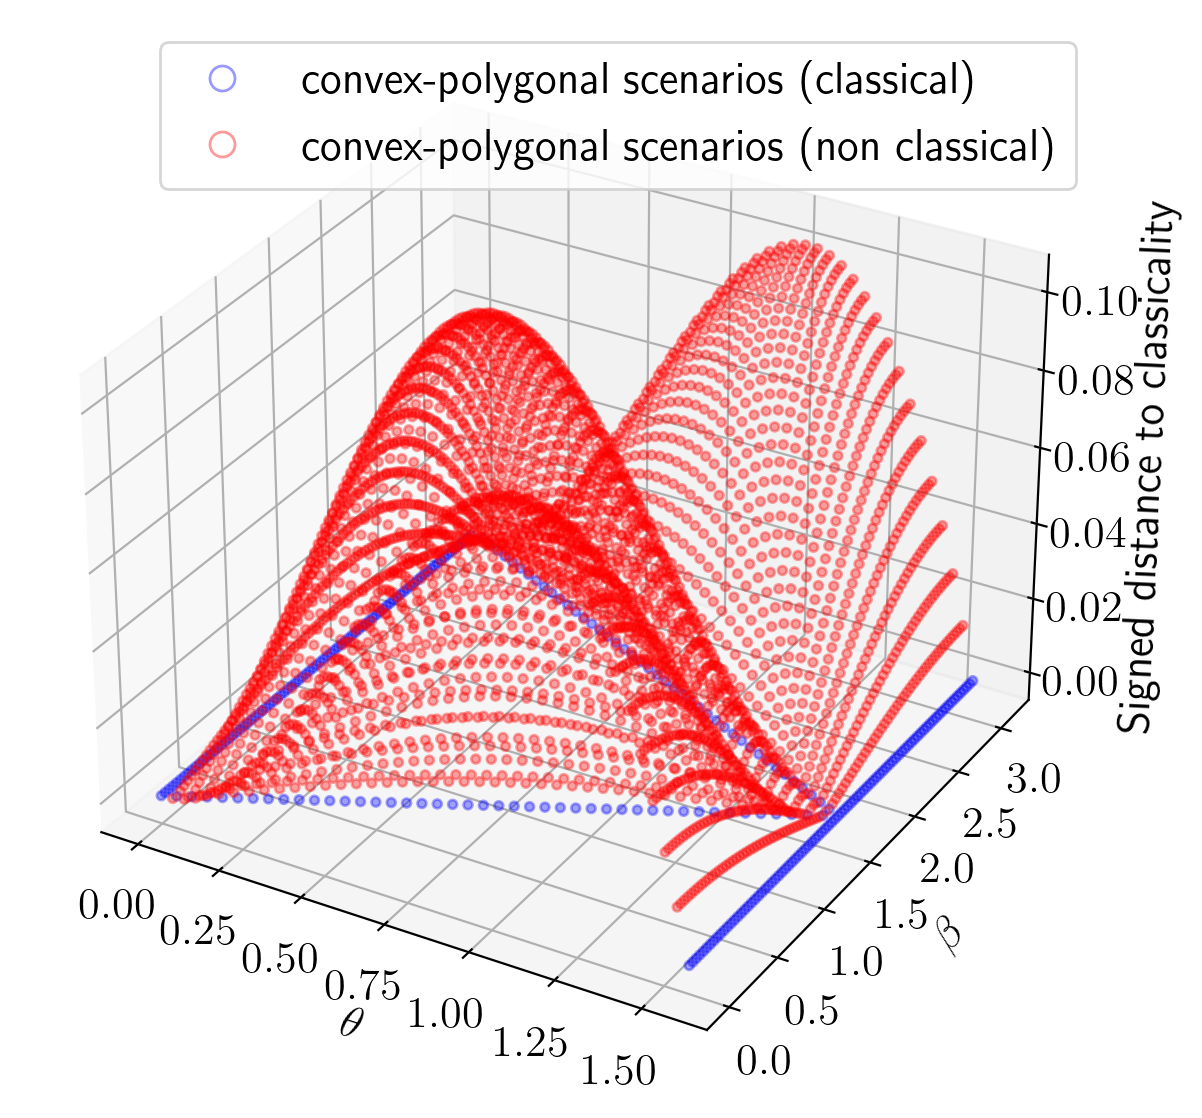

In [17]:
%config InlineBackend.figure_format = 'retina'
#%matplotlib qt

import matplotlib as mpl
import matplotlib.lines as mlines
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

mpl.rcParams.update({'font.size': 16})


classicality_colors = {True: 'blue', False: 'red'}
classicality_alphas = {True: 0.015, False: 0.6}
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111, projection='3d')


ax.scatter([run['theta'] for run in runs_class],
        [run['beta'] for run in runs_class],
        [np.float64(run['signed_distance_to_classicality']) for run in runs_class],
        label=None,
        marker='o', s=10,
        edgecolors='blue', facecolors='blue',
        alpha=0.35)

ax.scatter([run['theta'] for run in runs_nonclass],
        [run['beta'] for run in runs_nonclass],
        [np.float64(run['signed_distance_to_classicality']) for run in runs_nonclass],
        label=None,
        marker='o', s=10,
        edgecolors='red', facecolors='red',
        alpha=0.35)



plt.grid()

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel('Signed distance to classicality')



plt.legend(prop={'size': 20})

handles, labels = plt.gca().get_legend_handles_labels()
classical_legend   = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='blue', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (classical)')
nonclassical_legend = mlines.Line2D([], [], markerfacecolor='white', markeredgecolor='red', marker='o', alpha=0.4, markersize=9, linestyle='None',
                                         label='convex-polygonal scenarios (non classical)')

handles = handles +[classical_legend, nonclassical_legend]

plt.legend(handles=handles)

plt.show()

In [18]:
# investigation: at theta fixed, what beta yields the highest nonclassicality?
thetas_beta_yielding_highest_nonclass = []
thetas_highest_nonclass = []
for theta in thetas:
    theta_runs = [run for run in runs if np.isclose(run['theta'], theta)]
    theta_dist_imax = np.argmax([run['distance_to_classicality'] for run in theta_runs])
    theta_dist_max = theta_runs[theta_dist_imax]['distance_to_classicality']
    theta_beta_at_imax =  theta_runs[theta_dist_imax]['beta']
    
    thetas_beta_yielding_highest_nonclass.append( theta_beta_at_imax )
    thetas_highest_nonclass.append( np.float64(theta_dist_max) )

In [19]:
list(zip(thetas,thetas_beta_yielding_highest_nonclass, thetas_highest_nonclass))

[(0.0, 0.0, 0.0),
 (0.03569991651806583, 1.5707963267948966, 0.01405124934510332),
 (0.07139983303613166, 1.5707963267948966, 0.027046410108432107),
 (0.10709974955419749, 1.5707963267948966, 0.03897487418837567),
 (0.14279966607226333, 1.5707963267948966, 0.049831327295882286),
 (0.17849958259032916, 1.5707963267948966, 0.05961570534615338),
 (0.21419949910839498, 1.5707963267948966, 0.0683331243673847),
 (0.2498994156264608, 1.5707963267948966, 0.07599378437336887),
 (0.28559933214452665, 1.5707963267948966, 0.08261284777911256),
 (0.32129924866259246, 1.5707963267948966, 0.08821029306768945),
 (0.35699916518065833, 1.5707963267948966, 0.09281074454221577),
 (0.39269908169872414, 1.5707963267948966, 0.09644327911737254),
 (0.42839899821678995, 1.5707963267948966, 0.09914121122164696),
 (0.4640989147348558, 1.5707963267948966, 0.10094185699158956),
 (0.4997988312529216, 1.5707963267948966, 0.10188627904368464),
 (0.5354987477709875, 1.5707963267948966, 0.10201901320761969),
 (0.571198

Going from $\theta=0$ to $\theta=\pi/2$, we see that:

- from $\theta=0$ to $\theta=\pi/4$, choosing $\beta=\pi/2$ (i.e. the optimal $\beta$, score-wise) maximizes `distance_to_classicality`.
- from $\theta=\pi/4$ to $\theta=\pi/2$, choosing $\beta=0$ (i.e. the worst $\beta$, score-wise) maximizes `distance_to_classicality`.

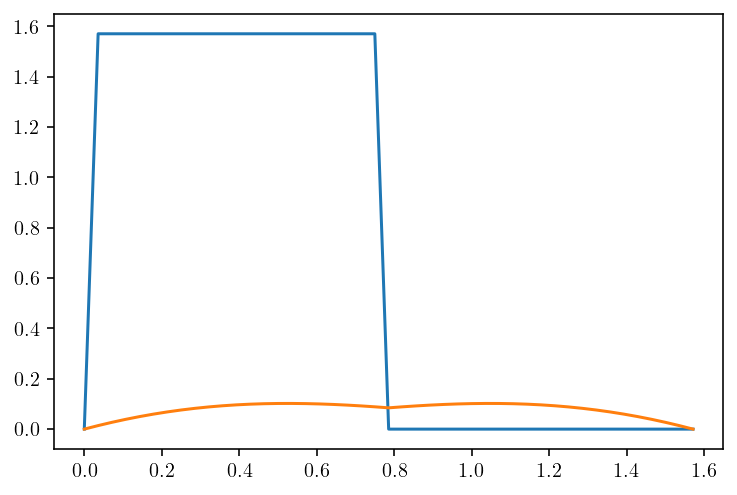

In [20]:
%matplotlib inline
plt.plot(thetas, thetas_beta_yielding_highest_nonclass)
plt.plot(thetas, thetas_highest_nonclass)